In [2]:
import pathlib
import pandas as pd
from ast import literal_eval
import cv2
from face_clustering_pipeline import FaceClusteringPipeline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
base_path = pathlib.Path("/media/bao/t7/la_lib_dataset")
# base_path = pathlib.Path("dataset")

src_folder = base_path / "img"
save_folder = base_path / "results40k"

dst_folder = save_folder / "faces"
dst_folder.mkdir(exist_ok=True, parents=True)
df_folder = save_folder / "df_test"
df_folder.mkdir(exist_ok=True, parents=True)
log_folder = save_folder / "log_test"
log_folder.mkdir(exist_ok=True, parents=True)

faceClusteringPipeline = FaceClusteringPipeline(src_folder, dst_folder, df_folder, log_folder)

In [4]:
# LOAD THE EMBEDDINGS

model_name = "Facenet512"
# df = pd.read_csv(df_folder / f"keep_representation_{model_name}.csv", index_col=0, converters={f"{model_name}_representation": literal_eval})
df1 = pd.read_csv("/media/bao/t7/la_lib_dataset/results/df/" + f"keep_representation_{model_name}.csv", index_col=0, converters={f"{model_name}_representation": literal_eval})
df2 = pd.read_csv("/media/bao/t7/la_lib_dataset/results2/df/" + f"keep_representation_{model_name}.csv", index_col=0, converters={f"{model_name}_representation": literal_eval})

In [3]:
min_samples = 5
threshold = 0.2375
model_name="Facenet512"
clustering_algo = "DBSCAN"
# quality = res_used

cluster_path = f"/media/bao/t7/la_lib_dataset/results40k/df/cluster_{model_name}_{clustering_algo}_cosine_{min_samples}_{threshold}.csv"
df_cluster = pd.read_csv(cluster_path, usecols=["image", "cluster_label"])

* Do 20k clustering (1)
* Do 20k clustering (2)
* Compute the average embedding for (1) and (2)
* AHC on the average embedding to merge the cluster ? 

In [5]:
# CLUSTERING 1
df1_res = faceClusteringPipeline.p_cluster_faces(df1, df_folder, model_name=model_name, clustering_algo="DBSCAN", distance_metric="cosine", min_samples=3, threshold=0.2375) 

In [6]:
# CLUSTERING 2
df2_res = faceClusteringPipeline.p_cluster_faces(df2, df_folder, model_name=model_name, clustering_algo="DBSCAN", distance_metric="cosine", min_samples=3, threshold=0.2375) 

In [7]:
# MAKE THE AVERAGE EMBEDDING
# ignore the outliers (-1)
# for each cluster, take the average embedding
# save the average embedding to a new dataframe df_avg_embed

def get_avg_embed(df: pd.DataFrame, id: int) -> pd.DataFrame:
    df_avg_embed = pd.DataFrame(columns=[f"avg_{model_name}_representation", "cluster_label"])

    # group by cluster_id
    for cluster_id, group in df.groupby("cluster_label"):
        # ignore the outliers (-1)
        if cluster_id == -1:
            continue
        
        cluster_name = f"df{id}_{cluster_id}"
        
        matrix = np.array(group[f"{model_name}_representation"].tolist())
        avg_embed = np.mean(matrix, axis=0)
        df_avg_embed = pd.concat([df_avg_embed, pd.DataFrame([[avg_embed, cluster_name]], columns=[f"avg_{model_name}_representation", "cluster_label"])], ignore_index=True)
    
    return df_avg_embed

In [8]:
df1_avg_embed = get_avg_embed(df1_res, 1)
df2_avg_embed = get_avg_embed(df2_res, 2)

df_avg_embed = pd.concat([df1_avg_embed, df2_avg_embed], ignore_index=True)

In [9]:
df1_res["src_folder"] = "1"
df2_res["src_folder"] = "2"
df_res = pd.concat([df1, df2], ignore_index=True)

In [10]:
# CLUSTERING WITH AHC
from sklearn.cluster import AgglomerativeClustering

X = np.array(df_avg_embed[f"avg_{model_name}_representation"].tolist())

clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.2375, linkage="average", affinity="cosine").fit(X)

In [11]:
df_avg_embed["pred_cluster_label"] = clustering.labels_

In [12]:
# match the cluster label with the original dataframe

def get_pred_cluster(row):
    cluster_id = row["cluster_label"]
    src_folder = row["src_folder"]
    if cluster_id == -1:
        return -1

    # print(f"df{src_folder}_{cluster_id}")
    pred_cluster_id = df_avg_embed[df_avg_embed["cluster_label"] == f"df{src_folder}_{cluster_id}"]["pred_cluster_label"].values[0]
    return pred_cluster_id

df_res["pred_cluster"] = df_res.apply(get_pred_cluster, axis=1)

In [13]:
def faceId_to_ogId(faceId: str) -> str:
    """
    Convert faceId to original Id

    @param faceId: faceId of image, eg 0-dHzE7f4Yd8PuTtTAKwAN_f0
    @return: original Id of image, eg 0-dHzE7f4Yd8PuTtTAKwAN
    """
    ogId = faceId.split("_f")[:-1] 
    ogId = "_f".join(ogId) # just in case there are more _f in the name
    return ogId

def show_cluster(df:pd.DataFrame, cluster_id: int, faces_folder: pathlib.Path, originals_folder: pathlib.Path, limit=50, ncol=5, show_original=False, plot=True, save_folder: pathlib.Path = None, hide_axis=False, title_col = None, marked: list[str] = []) -> list[str]:
    """
    Show cluster with cluster_id

    @param df: dataframe with at least columns: image (image name),
    cluster_label 
    @param cluster_id: cluster id to show
    @param faces_folder: folder contains faces images 
    @param originals_folder: folder contains original images
    @param limit: maximum number of images to show
    @param ncol: number of columns
    @param show_original: show original image or not (i.e. show face image)
    @param plot: plot the cluster or not
    @param save_folder: folder to save the plot
    @param hide_axis: hide axis or not
    @param title_col: column name to show as title
    @param marked: list of image id to mark with red border 
    
    @return: list of all ids in the cluster
    """
    
    cluster = df[df["cluster_label"] == cluster_id]
    cluster_size = cluster.shape[0]

    nrow = int(np.ceil(cluster_size / ncol))

    nb_subplots = nrow * ncol

    if plot:
        fig, axs = plt.subplots(nrow, ncol, figsize=(ncol*5, nrow*5))
        # fig.tight_layout()
        axs: list[plt.Axes] = axs.flatten()

    ids: list[str] = []

    # iterate over the cluster
    for i, (idx, row) in enumerate(cluster.iterrows()):
        image: str = row["image"] # face image name: eg. 0-dHzE7f4Yd8PuTtTAKwAN_f0.jpg
        img_src = faces_folder / image

        # reconstruct the original image path
        if show_original:
            img_suffix = img_src.suffix # .jpg
            img_orig = img_src.stem # 0-dHzE7f4Yd8PuTtTAKwAN_f0
            img_name = faceId_to_ogId(img_orig) # 0-dHzE7f4Yd8PuTtTAKwAN
            img_src = originals_folder / f"{img_name}{img_suffix}"

        id = img_src.stem # 0-dHzE7f4Yd8PuTtTAKwAN_f0 or 0-dHzE7f4Yd8PuTtTAKwAN

        ids.append(id)

        if not plot:
            continue

        # check if image exist
        if not img_src.exists():
            print(f"Image {img_src} does not exist")
            continue
    
        img = cv2.imread(str(img_src))

        try:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except:
            print(f"Image {img_src} is Corrupted")
            continue

        axs[i].imshow(img)

        if id in marked:
            for pos in ["top", "bottom", "left", "right"]:
                axs[i].spines[pos].set_edgecolor("red")
                axs[i].spines[pos].set_linewidth(3)
                
        # set title 
        if title_col is not None:
            title = row[title_col]
        else:
            title = f"{i}: {img_src.name} - {img.shape[0]}x{img.shape[1]}"
        axs[i].set_title(title)
        if hide_axis:
            axs[i].axis("off")
        
        if i >= limit:
            break
    
    # hide all the remaining axis
    if plot:
        for i in range(cluster_size, nb_subplots):
            axs[i].axis("off")

    if plot and save_folder:
        fig.savefig(save_folder / f"cluster_{cluster_id}.png")
        plt.close(fig)
         
    return ids

In [16]:
df_res["pred_cluster"].value_counts()[:20]

-1      34181
 81      3064
 27        86
 43        37
 93        35
 55        31
 85        29
 76        28
 159       27
 53        26
 40        25
 82        25
 182       23
 30        23
 109       21
 149       21
 158       20
 832       19
 688       18
 318       18
Name: pred_cluster, dtype: int64

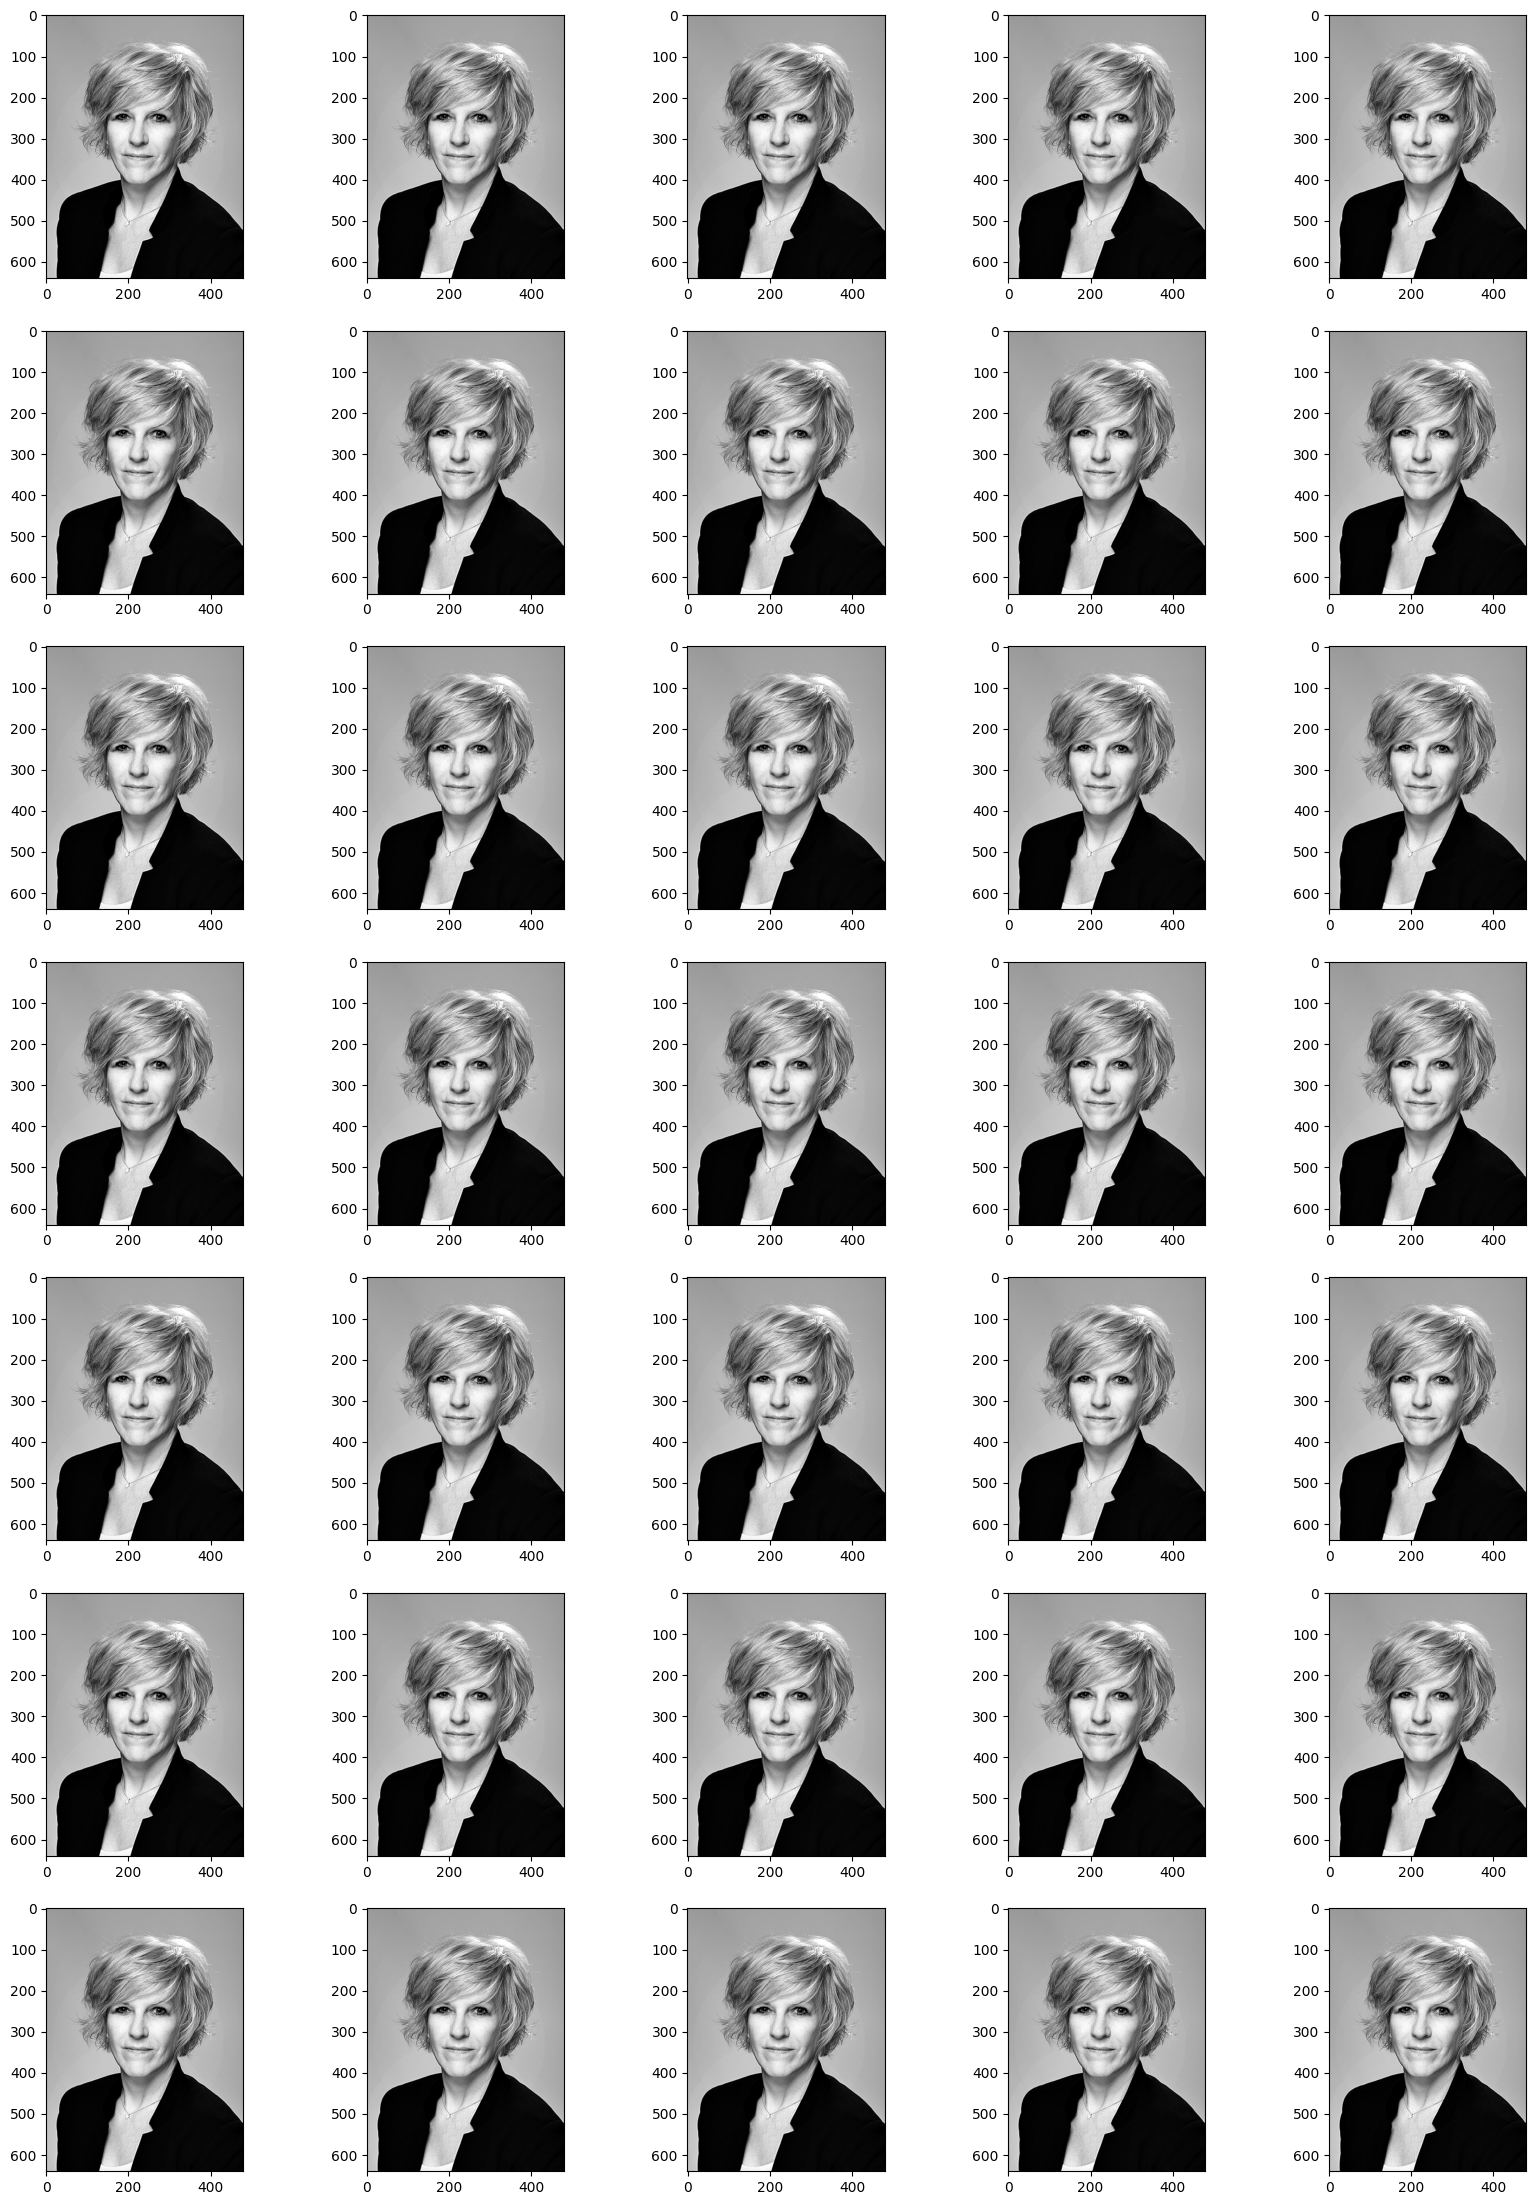

In [17]:
show_cluster(df_res, 93)

60


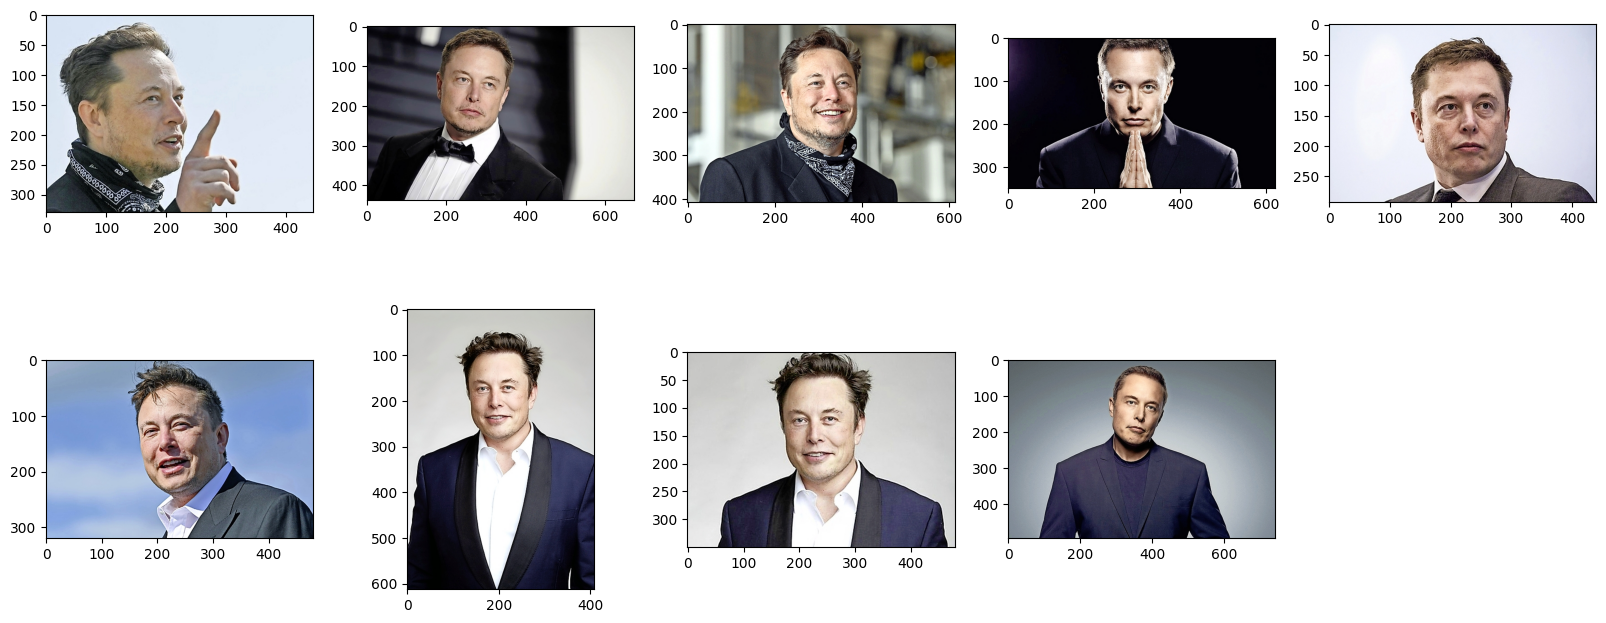

In [19]:
show_id = df_res[df_res["image"].str.startswith("2tGZUpFQ4Nn9a7GqBw9ZJy")]["pred_cluster"].values[0]
print(show_id)
if show_id not in [-1, 0]:
    show_cluster(df_res, show_id)